<a href="https://colab.research.google.com/github/markerenberg/Toxic-Comment-Classification/blob/master/LSTM_Model_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Check if GPU is enabled
import tensorflow as tf
tf.test.gpu_device_name()

In [1]:
##
## =======================================================
## Mark Erenberg 
## Toxic Comment Classification Challenge
## =======================================================
##

# Objective: Create a model which predicts a probability of each type of toxicity for each comment.

# import dependencies and files

import os
import time
import pandas as pd
import numpy as np
from scipy import sparse
from scipy.sparse import hstack
import itertools
import matplotlib.pyplot as plt
import re
import tempfile
import warnings

import lightgbm as lgb

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize

import gensim
import gensim.models.keyedvectors as word2vec
from gensim.models.fasttext import FastText
from gensim.models.word2vec import Word2Vec

import spacy
import en_core_web_sm
spacy_nlp = en_core_web_sm.load()
spacy_nlp = spacy.load('en_core_web_sm')
from spacy.lemmatizer import Lemmatizer

from collections import Counter, defaultdict

from sklearn import utils
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Bidirectional, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.optimizers import Adam
from keras.callbacks import Callback

################### Data Loading ###################
#os.chdir('C:\\Users\\marke\\Downloads\\Toxic Classification')
train = pd.read_csv('train.csv').fillna('')
test = pd.read_csv('test.csv').fillna('')

train_text = train[['id','comment_text']].drop_duplicates()
df = pd.concat([train_text,test],axis=0,ignore_index=True)

################### Data Cleaning ####################
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
cv = CountVectorizer(min_df=0., max_df=1.)

# Simple way to get the number of occurence of a regex
def count_regexp_occ(regexp="", text=None):
    return len(re.findall(regexp, text))

# Determine if file words exist:
#print(len(df[df['comment_text'].str.contains('jpg')]))
#print(len(df[df['comment_text'].str.contains('jpeg')]))
#print(len(df[df['comment_text'].str.contains('http')]))
#print(len(df[df['comment_text'].str.contains('pdf')]))
#print(len(df[df['comment_text'].str.contains('html')]))

# Remove non-alphabetic characters and split tokens by spaces/newlines
def clean_document(doc):
    # 1) Convert string to lower
    #doc = bytes(doc.lower(), encoding="utf-8")
    doc = doc.lower()
    # 2) Replace contracion patterns
    cont_patterns = [
    (r'(W|w)on\'t', r'will not'),
    (r'(C|c)an\'t', r'can not'),
    (r'(I|i)\'m', r'i am'),
    (r'(A|a)in\'t', r'is not'),
    (r'(\w+)\'ll', r'\g<1> will'),
    (r'(\w+)n\'t', r'\g<1> not'),
    (r'(\w+)\'ve', r'\g<1> have'),
    (r'(\w+)\'s', r'\g<1> is'),
    (r'(\w+)\'re', r'\g<1> are'),
    (r'(\w+)\'d', r'\g<1> would'),
    ]
    patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]
    for (pattern, repl) in patterns:
        doc = re.sub(pattern, repl, doc)
    # 3) Remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]+', '', doc)
    #doc = doc.encode('utf-8')
    #doc = str(doc,'utf-8').strip()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    #doc = ' '.join(tokens)
    return doc

# Lemmaitze comments:
def lemmatize_comment(comment):
        doc = spacy_nlp(comment)
        return [token.lemma_ for token in doc if token.lemma_ != '-PRON-' ]         


## Clean and lemmatize comments
#df['clean_comments'] = [clean_document(x) for x in df['comment_text']]
#df['clean_comments_list'] = df['clean_comments'].apply(lambda x: x.split())
#df['clean_lemmed'] = [lemmatize_comment(x) for x in df['clean_comments']]
#df['clean_lemmed_str'] = df['clean_lemmed'].apply(lambda x: " ".join(x))
train['clean_comments'] = [clean_document(x) for x in train['comment_text']]
train['clean_comments_list'] = train['clean_comments'].apply(lambda x: x.split())
train['clean_lemmed'] = [lemmatize_comment(x) for x in train['clean_comments']]
train['clean_lemmed_str'] = train['clean_lemmed'].apply(lambda x: " ".join(x))

## Write to csv for download
#from google.colab import drive
#drive.mount('/content/drive')
train['clean_lemmed'].to_csv('train_clean_lemmed.csv',sep=',',index=False)

#train_clean_comments = pd.read_csv('train_clean_comments.csv',header=None)
#train_clean_lemmed = pd.read_csv('train_clean_lemmed.csv',header=None)
#train['clean_comments'] = train_clean_comments
#train['clean_comments_list'] = train['clean_comments'].apply(lambda x: x.split())
#train['clean_lemmed'] = train_clean_lemmed
#train['clean_lemmed_str'] = train['clean_lemmed'].apply(lambda x: " ".join(x))

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
train['clean_lemmed'].to_csv('train_clean_lemmed.csv',sep=',',index=False)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


[0]

In [6]:
train['clean_lemmed'].to_csv("train_clean_lemmed.csv",index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [0]:
##### Declare Variables #####
seed = 1234
splits = 5
folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)
resp = 'severe_toxic'
y = train[resp]
class_pred = np.zeros(len(train['clean_comments']))
auc,precision,recall,thresholds = [],[],[],[]


Found 218759 unique tokens.


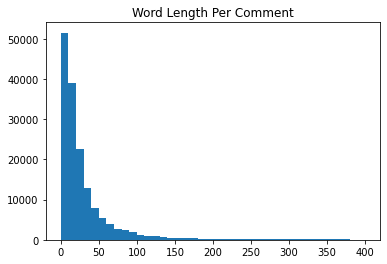

Shape of data tensor: (159571, 200)


In [4]:
##### LSTM using Keras #####

## Declare parameters for pre-processing
max_words = 20000
max_seq_length = 200

## Tokenize text, convert to list of indices
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(train['clean_comments'])
word_index = tokenizer.word_index
print('Found {} unique tokens.'.format(len(word_index)))
X = tokenizer.texts_to_sequences(train['clean_comments'])

## Plot word length per comment to find good cutoff for max_seq_len
#totalNumWords = [len(one_comment) for one_comment in X]
#plt.hist(totalNumWords,bins = np.arange(0,410,10))
#plt.title("Word Length Per Comment")
#plt.show()

## Plot word length per comment to find good cutoff for max_seq_len
totalNumWords = [len(one_comment) for one_comment in X]
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.title("Word Length Per Comment")
plt.show()

## Convert list of indices to ndarray, padding sequences
X = pad_sequences(X, maxlen=max_seq_length)
print('Shape of data tensor:', X.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = seed)

In [5]:
## Define hyperparameters
embedding_dim = 300
lstm_units=200
drop_out = 0.2
epochs = 10
batch_size = 64

## Compile model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=X.shape[1]))
model.add(Bidirectional(LSTM(lstm_units)))
model.add(Dropout(drop_out))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          6000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 400)               801600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 401       
Total params: 6,802,001
Trainable params: 6,802,001
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
## Fit model
import warnings
warnings.filterwarnings("ignore")

print("Begin training for class {}".format(resp))
t0 = time.time()
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
print("Model Training Finished | Time: {}m".format(str(round((time.time()-t0)/60,2))))


Begin training for class severe_toxic



Train on 102124 samples, validate on 25532 samples
Epoch 1/10





102124/102124 [==============================] - 1215s 12ms/step - loss: 0.0365 - acc: 0.9893 - val_loss: 0.0255 - val_acc: 0.9906
Epoch 2/10
 54336/102124 [==============>...............] - ETA: 8:32 - loss: 0.0224 - acc: 0.9904

In [0]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

31915/31915 [==============================] - 55s 2ms/step
Test set
  Loss: 0.051
  Accuracy: 0.989


In [0]:
preds = model.predict(X_test)

In [0]:
preds[:10]

array([[1.2516975e-06],
       [2.6184320e-04],
       [6.2584877e-07],
       [2.6822090e-07],
       [5.0872564e-05],
       [5.9604645e-07],
       [3.4570694e-06],
       [2.0861626e-07],
       [1.0812283e-03],
       [2.0265579e-06]], dtype=float32)

In [0]:
#from sklearn.metrics import classification_report
#print(classification_report(y_test,preds))

# Plot precision-recall curve
prec, recal, thresh = precision_recall_curve(y_test, preds)
plt.figure()
plt.plot(recal, prec, 'ro', linewidth=2,label='Test Set Preds')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Class: '+resp+' | Average Precision: '+str(average_precision_score(y_test,preds,average='weighted')))
plt.legend()
plt.show()